In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df_pods = pd.read_csv("/data/pods_request.csv")
df_nodes = pd.read_csv("/data/nodes_allocatable.csv")

# Convert timestamp column to datetime
df_pods['timestamp'] = pd.to_datetime(df_pods['timestamp'])
df_nodes['timestamp'] = pd.to_datetime(df_nodes['timestamp'])

/tmp/ipykernel_1110671/3954530639.py:2: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_nodes = pd.read_csv("/data/aws-exp/aws_open_data/nodes_allocatable_anonymized.csv")


In [7]:
# Check for Nan values
print("Pods file # of NaN values: ", df_pods.isnull().sum().sum())

# In Nodes file, we dont check Status and Ccondition column as they include NaN values for indicating an inactive node
print("Nodes file # of NaN values: ", df_nodes[['timestamp', 'node',	'cpu',	'memory',	'nvidia_com_gpu',	'scenario']].isnull().sum().sum())

Pods file # of NaN values:  0
Nodes file # of NaN values:  0


### Cpu/Memory/GPU Demand Over Time Percentage

In [8]:
# Get the running Nodes
df_nodes_true = df_nodes[(df_nodes.condition == "Ready") & (df_nodes.status == True)]

# Summarize the resources of running nodes
sum_cpu_nodes_true = df_nodes_true.groupby(by="timestamp")["cpu"].sum().values
sum_memory_nodes_true = df_nodes_true.groupby(by="timestamp")["memory"].sum().values
sum_gpu_nodes_true = df_nodes_true.groupby(by="timestamp")["nvidia_com_gpu"].sum().values

# Summarize the resources of all nodes
sum_cpu_nodes = df_nodes.groupby(by="timestamp")["cpu"].sum().values 
sum_memory_nodes = df_nodes.groupby(by="timestamp")["memory"].sum().values 
sum_gpu_nodes = df_nodes.groupby(by="timestamp")["nvidia_com_gpu"].sum().values 

node_cpu = np.divide(sum_cpu_nodes_true, sum_cpu_nodes) * 100
node_memory = np.divide(sum_memory_nodes_true, sum_memory_nodes) * 100
node_gpu = np.divide(sum_gpu_nodes_true, sum_gpu_nodes) * 100

# Summurize Pods requests per resource
sum_cpu_pods = df_pods.groupby(by="timestamp")["cpu"].sum().values
sum_memory_pods = df_pods.groupby(by="timestamp")["memory"].sum().values
sum_gpu_pods = df_pods.groupby(by="timestamp")["nvidia_com_gpu"].sum().values

pods_cpu = np.divide(sum_cpu_pods, sum_cpu_nodes) * 100
pods_memory = np.divide(sum_memory_pods, sum_memory_nodes) * 100
pods_gpu = np.divide(sum_gpu_pods, sum_gpu_nodes) * 100

timestamps = df_nodes.timestamp.unique()

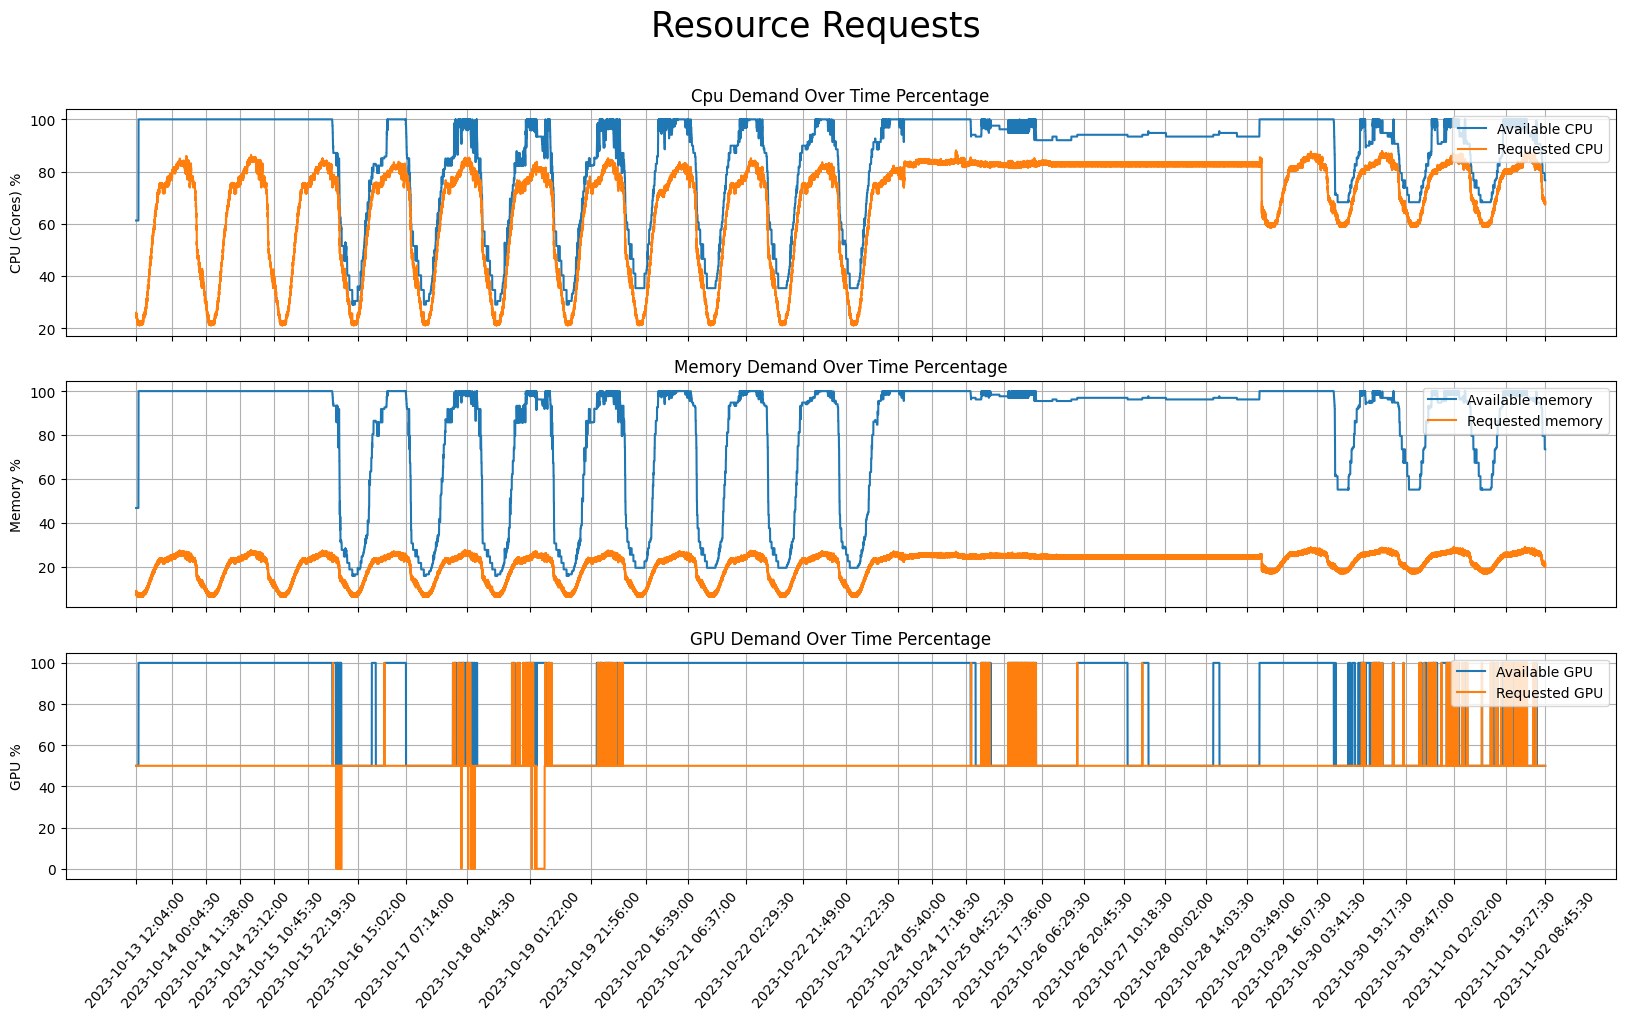

In [10]:
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(20,10))

# Finding the last timestamp for each category
last_timestamps = df_nodes.groupby('scenario')['timestamp'].max().tolist()

fig.suptitle('Resource Requests', fontsize=25)

axs[0].plot(timestamps, node_cpu, label="Available CPU")
axs[0].plot(timestamps, pods_cpu, label="Requested CPU")
axs[0].set_title("Cpu Demand Over Time Percentage")
axs[0].set_ylabel("CPU (Cores) %")
axs[0].grid(True)
axs[0].legend(loc="upper right")
# axs[0].vlines(x=last_timestamps[:-1], ymin=[0, 0, 0, 0, 0, 0], ymax=[100, 100, 100, 100, 100, 100], colors='red', ls='--', lw=2, )

axs[1].plot(timestamps, node_memory, label="Available memory")
axs[1].plot(timestamps, pods_memory, label="Requested memory")
axs[1].set_title("Memory Demand Over Time Percentage")
axs[1].set_ylabel("Memory %")
axs[1].grid(True)
axs[1].legend(loc="upper right")
# axs[1].vlines(x=last_timestamps[:-1], ymin=[0, 0, 0, 0, 0, 0], ymax=[100, 100, 100, 100, 100, 100], colors='red', ls='--', lw=2, )

axs[2].plot(timestamps, node_gpu, label="Available GPU")
axs[2].plot(timestamps, pods_gpu, label="Requested GPU")
axs[2].set_title("GPU Demand Over Time Percentage")
axs[2].set_ylabel("GPU %")
axs[2].grid(True)
axs[2].legend(loc="upper right")
# axs[2].vlines(x=last_timestamps[:-1], ymin=[0, 0, 0, 0, 0, 0], ymax=[100, 100, 100, 100, 100, 100], colors='red', ls='--', lw=2, )

# Setting the xticks and rotating the labels
n = 32
ticks = df_nodes_true['timestamp'][::len(df_nodes_true)//n].tolist()
axs[2].set_xticks(ticks)
axs[2].set_xticklabels([pd.to_datetime(str(t)).strftime('%Y-%m-%d %H:%M:%S') for t in ticks])
axs[2].tick_params(axis='x', rotation=50)

plt.show()

### Workloads per scenario

In [2]:
df_pods_workload = pd.read_csv("/data/pods_request_workloads.csv")
# Convert timestamp column to datetime
df_pods_workload['timestamp'] = pd.to_datetime(df_pods_workload['timestamp'])

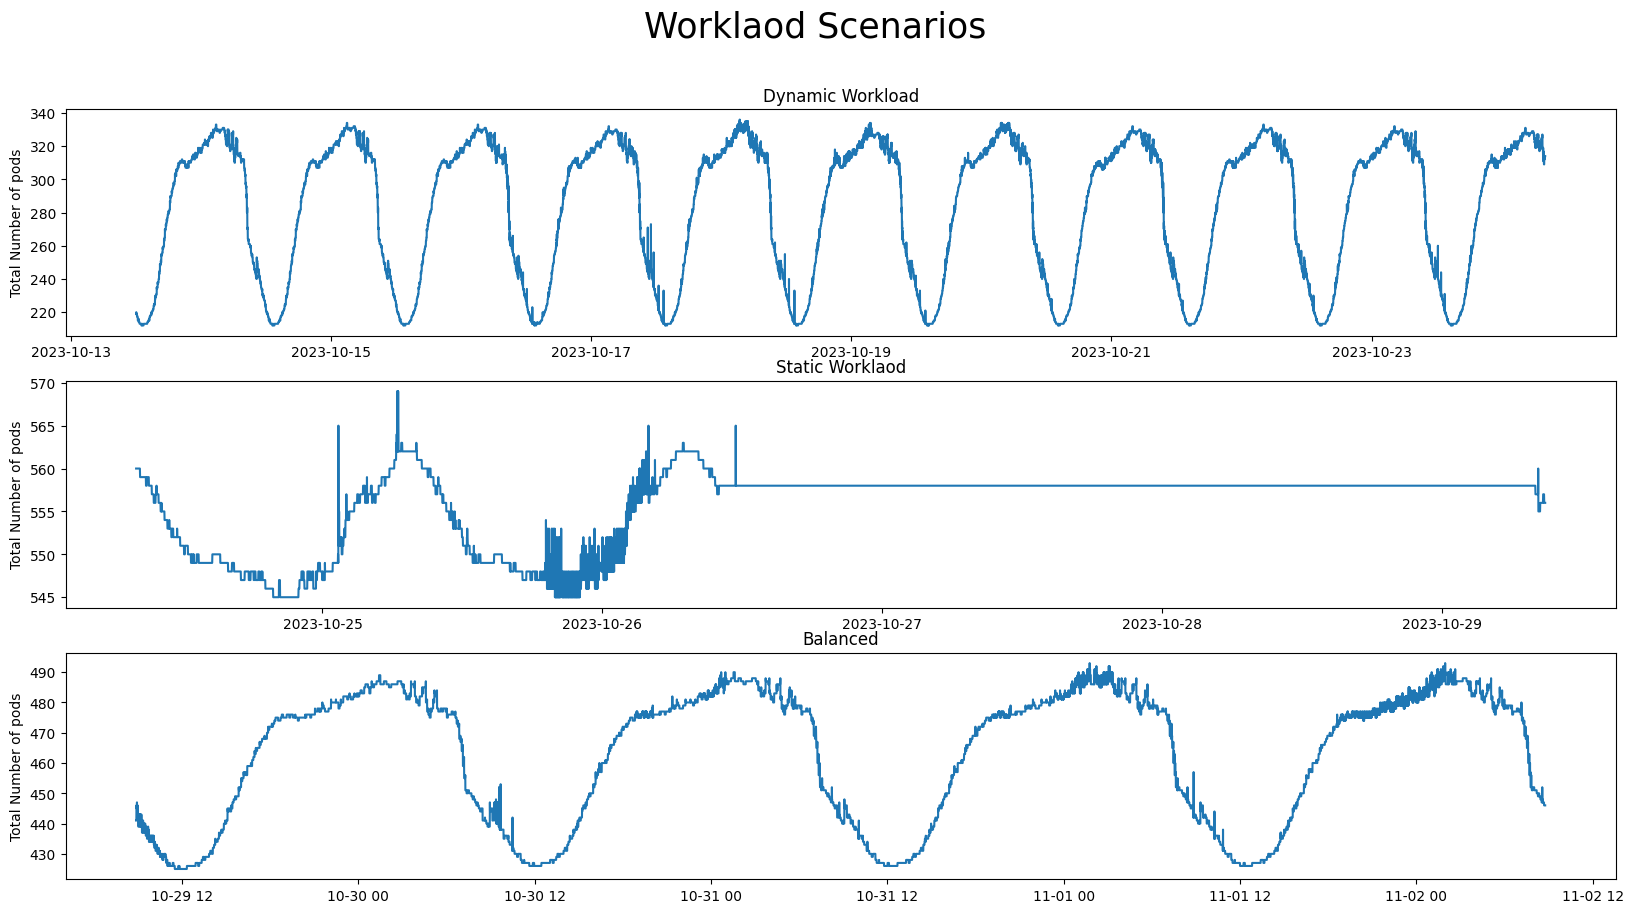

In [4]:
fig, axs = plt.subplots(3, 1, figsize=(20,10))

fig.suptitle('Worklaod Scenarios', fontsize=25)

axs[0].plot(df_pods_workload[df_pods_workload.scenario == "A"].timestamp.unique(), df_pods_workload[df_pods_workload.scenario == "A"].groupby('timestamp')['uid'].nunique().values)
axs[0].set_title("Dynamic Workload")
axs[0].set_ylabel("Total Number of pods")

axs[1].plot(df_pods_workload[df_pods_workload.scenario == "B"].timestamp.unique(), df_pods_workload[df_pods_workload.scenario == "B"].groupby('timestamp')['uid'].nunique().values)
axs[1].set_title("Static Worklaod")
axs[1].set_ylabel("Total Number of pods")

axs[2].plot(df_pods_workload[df_pods_workload.scenario == "C"].timestamp.unique(), df_pods_workload[df_pods_workload.scenario == "C"].groupby('timestamp')['uid'].nunique().values)
axs[2].set_title("Balanced")
axs[2].set_ylabel("Total Number of pods")

plt.show()

### Total Ready Nodes

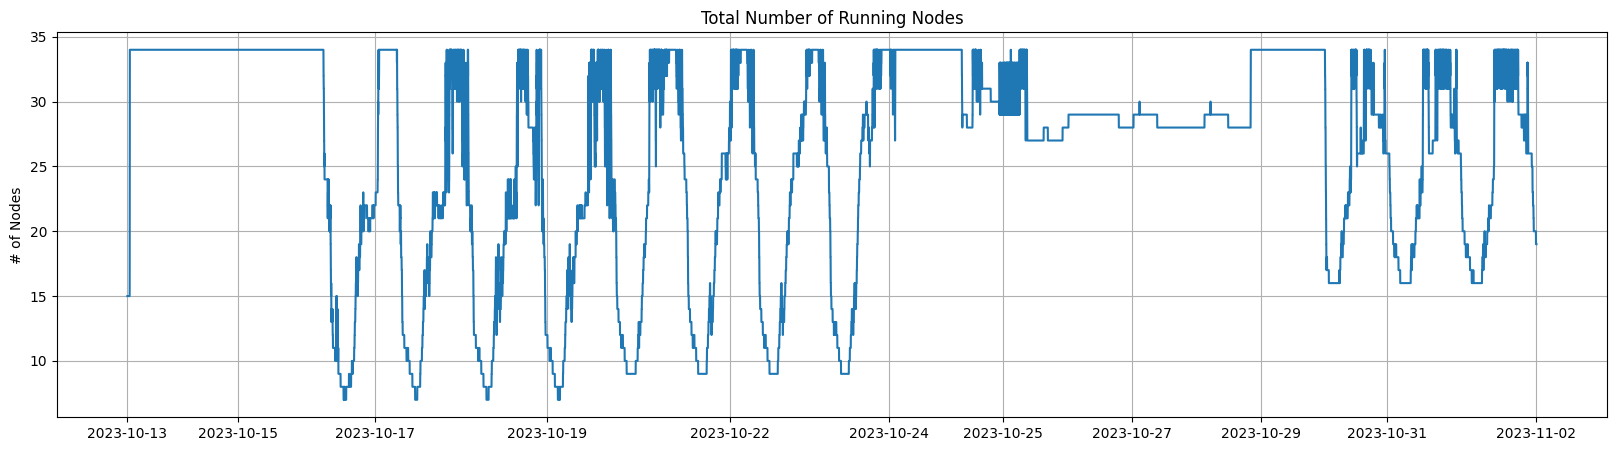

In [11]:
# Filter the DataFrame based on the 'status' column
df_true_nodes = df_nodes[(df_nodes.condition == "Ready") & (df_nodes.status == True)]

plt.figure(figsize=(20,5))
plt.plot(df_true_nodes.timestamp.unique(), df_true_nodes.groupby('timestamp')['node'].nunique().values, label="Available CPU")
n = 10
ticks = df_nodes_true['timestamp'][::len(df_nodes_true)//n].tolist()
plt.xticks(ticks)
plt.ylabel("# of Nodes")
plt.grid(True)
plt.title("Total Number of Running Nodes")
plt.show()

### Total Running Pods

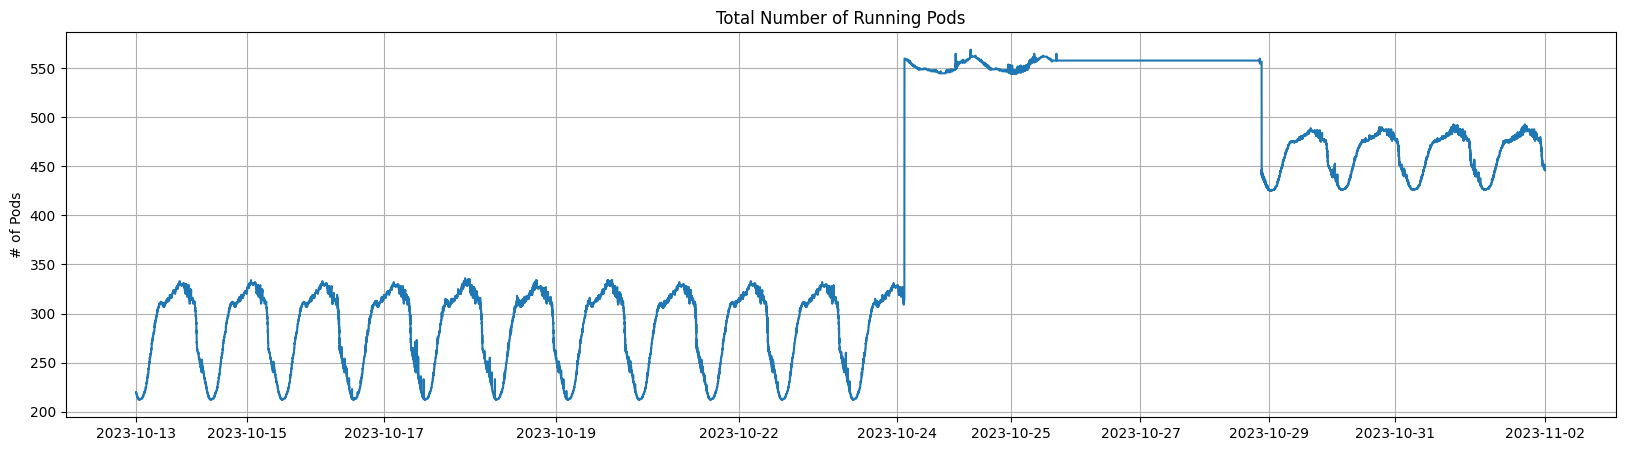

In [12]:
plt.figure(figsize=(20,5))
plt.plot(df_pods.timestamp.unique(), df_pods.groupby('timestamp')['uid'].nunique().values, label="Available CPU")
n = 10
ticks = df_nodes_true['timestamp'][::len(df_nodes_true)//n].tolist()
plt.xticks(ticks)
plt.ylabel("# of Pods")
plt.grid(True)
plt.title("Total Number of Running Pods")
plt.show()